# Прогнозирование оттока для фитнес-центра

## Описание проекта

Сеть фитнес-центров разрабатывает стратегию взаимодействия с клиентами на основе аналитических данных, чтобы снизить отток клиентов. Фитнес-центр считает, что клиент попал в отток, если за последний месяц ни разу не посетил спортзал. Задача — провести анализ и подготовить план действий по удержанию клиентов.

А именно:

- прогнозировать вероятность оттока (на уровне следующего месяца) для каждого клиента;
- сформировать типичные портреты клиентов: выделить несколько наиболее ярких групп и охарактеризовать их основные свойства;
- проанализировать основные признаки, наиболее сильно влияющие на отток;
- сформулировать основные выводы и разработать рекомендации по повышению качества работы с клиентами:

1. выделить целевые группы клиентов;
2. предложить меры по снижению оттока;
3. определить другие особенности взаимодействия с клиентами.

Для анализа факторов, влияющих на отток было переведено в электронный вид множество клиентских анкет. Они содержат данные на месяц до оттока и факт оттока на определённый месяц и включают следующие поля:

Данные клиента за предыдущий до проверки факта оттока месяц:

        'gender' — пол;
        'Near_Location' — проживание или работа в районе, где находится фитнес-центр;
        'Partner' — сотрудник компании-партнёра клуба (сотрудничество с компаниями, чьи сотрудники могут получать скидки на абонемент — в таком случае фитнес-центр хранит информацию о работодателе клиента);
        'Promo_friends' — факт первоначальной записи в рамках акции «приведи друга» (использовал промо-код от знакомого при оплате первого абонемента);
        'Phone' — наличие контактного телефона;
        'Age' — возраст;
        'Lifetime' — время с момента первого обращения в фитнес-центр (в месяцах).

Информация на основе журнала посещений, покупок и информация о текущем статусе абонемента клиента:

        'Contract_period' — длительность текущего действующего абонемента (месяц, 6 месяцев, год);
        'Month_to_end_contract' — срок до окончания текущего действующего абонемента (в месяцах);
        'Group_visits' — факт посещения групповых занятий;
        'Avg_class_frequency_total' — средняя частота посещений в неделю за все время с начала действия абонемента;
        'Avg_class_frequency_current_month' — средняя частота посещений в неделю за предыдущий месяц;
        'Avg_additional_charges_total' — суммарная выручка от других услуг фитнес-центра: кафе, спорттовары, косметический и массажный салон.
        'Churn' — факт оттока в текущем месяце.

## Импорты и первичный анализ

Импортируем библиотеки, с которыми будем работать.

In [1]:
import os
import pandas as pd
import numpy as np
import itertools

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage 

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

Получим первичную информацию по таблице.

In [2]:
if os.path.exists('gym_churn.csv'):
    data = pd.read_csv('gym_churn.csv')
else:
    data = pd.read_csv('/datasets/gym_churn.csv')

In [3]:
print(data.columns)
display(data.sample(10))
print(data.info(memory_usage = 'deep'))
print()
print('Количество пропущенных значений:')
print(data.isna().sum())
print()
print('Количество полных дубликатов:', data.duplicated().sum())

Index(['gender', 'Near_Location', 'Partner', 'Promo_friends', 'Phone',
       'Contract_period', 'Group_visits', 'Age',
       'Avg_additional_charges_total', 'Month_to_end_contract', 'Lifetime',
       'Avg_class_frequency_total', 'Avg_class_frequency_current_month',
       'Churn'],
      dtype='object')


,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
1081,1,1,1,0,1,6,0,27,98.087479,6.0,2,3.057608,3.033944,0
2263,0,1,0,0,1,1,0,29,136.884351,1.0,3,1.035399,0.328367,1
3279,1,0,1,1,1,1,0,28,127.449441,1.0,4,3.299562,3.414496,0
2226,1,1,1,0,1,6,0,27,180.676788,5.0,2,0.478517,0.335280,0
2575,0,1,0,0,1,1,1,26,277.882488,1.0,3,2.380329,2.543672,0
3814,0,1,0,0,1,12,0,31,147.365104,12.0,6,1.714738,1.623203,0
1450,1,1,1,1,1,12,1,31,326.367422,8.0,4,3.374454,3.393701,0
1528,0,1,1,0,1,12,1,29,136.409092,11.0,4,1.736799,1.666937,0
2822,0,1,0,1,1,1,0,28,208.502834,1.0,0,2.305537,1.923776,1
3641,0,1,0,0,1,1,0,30,136.218964,1.0,0,1.420072,1.364910,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total          4000 non-null   float

Видим, что у нас нет пропущенных значений или дубликатов. Есть столбцы (предположительно) с категориальными значениями в диапазоне 0-1, где 0 - отсутствие признака, а 1 - его присутствие (исключение - gender).

Типы данных определены верно. Возможно, можно перевести 'Month_to_end_contract' в int64, но это не существенно и ни на что не повлияет. Чтобы было легче работать с таблицей, переведём названия столбцов в lowercase.

In [4]:
data.columns = data.columns.str.lower()

Изучим данные с помощью describe.

In [5]:
data.describe(include='all').round(2)

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
count,4000.00,4000.00,4000.00,4000.00,4000.0,4000.00,4000.00,4000.00,4000.00,4000.00,4000.00,4000.00,4000.00,4000.00
mean,0.51,0.85,0.49,0.31,0.9,4.68,0.41,29.18,146.94,4.32,3.72,1.88,1.77,0.27
std,0.50,0.36,0.50,0.46,0.3,4.55,0.49,3.26,96.36,4.19,3.75,0.97,1.05,0.44
min,0.00,0.00,0.00,0.00,0.0,1.00,0.00,18.00,0.15,1.00,0.00,0.00,0.00,0.00
25%,0.00,1.00,0.00,0.00,1.0,1.00,0.00,27.00,68.87,1.00,1.00,1.18,0.96,0.00
50%,1.00,1.00,0.00,0.00,1.0,1.00,0.00,29.00,136.22,1.00,3.00,1.83,1.72,0.00
75%,1.00,1.00,1.00,1.00,1.0,6.00,1.00,31.00,210.95,6.00,5.00,2.54,2.51,1.00
max,1.00,1.00,1.00,1.00,1.0,12.00,1.00,41.00,552.59,12.00,31.00,6.02,6.15,1.00


### Выводы

1. Видим, что гипотеза про категориальные значения подтвердилась (min = 0 & max = 1). 
2. 50% от всех пользователей покупают абонемент на 1 месяц и не посещают групповые занятия (0).
3. Возрастной размах небольшой: от 50% пользователей попадают в диапазон 27-31 лет.
4. Медианный лайфтайм приходится на 3 месяца. Посещаемость 1-2 раза в неделю. В текущем месяце эта цифра незначительно снизилась.
5. Также по таблице видим, что отток наблюдается у 27% выборки.

## Исследовательский анализ данных (EDA)

### Описание данных

Посмотрим на средние значения признаков в 2-х группах: тех, кто ушёл и остался.

In [6]:
# те, кто ушёл
data.query('churn == 1').describe(include='all').round(2)

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
count,1061.00,1061.00,1061.00,1061.00,1061.0,1061.00,1061.00,1061.00,1061.00,1061.00,1061.00,1061.00,1061.00,1061.0
mean,0.51,0.77,0.36,0.18,0.9,1.73,0.27,26.99,115.08,1.66,0.99,1.47,1.04,1.0
std,0.50,0.42,0.48,0.39,0.3,2.13,0.44,2.90,77.70,1.96,1.11,0.69,0.77,0.0
min,0.00,0.00,0.00,0.00,0.0,1.00,0.00,18.00,0.15,1.00,0.00,0.00,0.00,1.0
25%,0.00,1.00,0.00,0.00,1.0,1.00,0.00,25.00,50.63,1.00,0.00,1.01,0.42,1.0
50%,1.00,1.00,0.00,0.00,1.0,1.00,0.00,27.00,103.81,1.00,1.00,1.49,0.98,1.0
75%,1.00,1.00,1.00,0.00,1.0,1.00,1.00,29.00,165.62,1.00,1.00,1.96,1.59,1.0
max,1.00,1.00,1.00,1.00,1.0,12.00,1.00,38.00,425.54,12.00,9.00,3.48,3.54,1.0


In [7]:
# те, кто остался
data.query('churn == 0').describe(include='all').round(2)

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
count,2939.00,2939.00,2939.00,2939.00,2939.0,2939.00,2939.00,2939.00,2939.00,2939.00,2939.00,2939.00,2939.00,2939.0
mean,0.51,0.87,0.53,0.35,0.9,5.75,0.46,29.98,158.45,5.28,4.71,2.02,2.03,0.0
std,0.50,0.33,0.50,0.48,0.3,4.72,0.50,3.01,99.80,4.36,3.87,1.02,1.02,0.0
min,0.00,0.00,0.00,0.00,0.0,1.00,0.00,19.00,0.17,1.00,0.00,0.00,0.00,0.0
25%,0.00,1.00,0.00,0.00,1.0,1.00,0.00,28.00,76.92,1.00,2.00,1.28,1.30,0.0
50%,1.00,1.00,1.00,0.00,1.0,6.00,0.00,30.00,149.88,6.00,4.00,2.04,2.05,0.0
75%,1.00,1.00,1.00,1.00,1.0,12.00,1.00,32.00,224.45,10.00,6.00,2.73,2.74,0.0
max,1.00,1.00,1.00,1.00,1.0,12.00,1.00,41.00,552.59,12.00,31.00,6.02,6.15,0.0


#### Выводы

Если сравнивать тех, кто ушёл, и кто остался, то мы можем заметить следующие отличия:

1. Группа лояльных клиентов в целом немного ближе по месторасположению к фитнес-центру (87% против 77%). 
2. Они более охотно делятся промо-кодами (35% против 18%), посещают групповые занятия (46% против 27%) и берут абонемент, в среднем, не на 1 месяц, а сразу на полгода.
3. Чаще, это люди, компания которых заключила партнёрский договор с фитнес-центром (53% против 36% оттока).
3. По возрасту они старше и, вероятно, более платёжеспособны. Размах пользователей оттока 25-29 лет, а средние доп. траты - 115. В группе лояльных возраст 28-32, и средние доп. расходы - 158.
4. Лайфтайм у ушедших пользователей - 1 месяц. Вероятно, это те пользователи, которые взяли абонемент, попробовали, не понравилось, и они ушли. У тех, кто остаётся с фитнес-центром, медианный лайфтайм - 4 месяца. Они стабильно ходят 2 раза в неделю в отличие от людей с оттоком, у кого эта цифра колеблется между 1-2 раза/неделю.

### Гистограмма

Построим гистограммы признаков для тех, кто ушёл, и тех, кто остался.

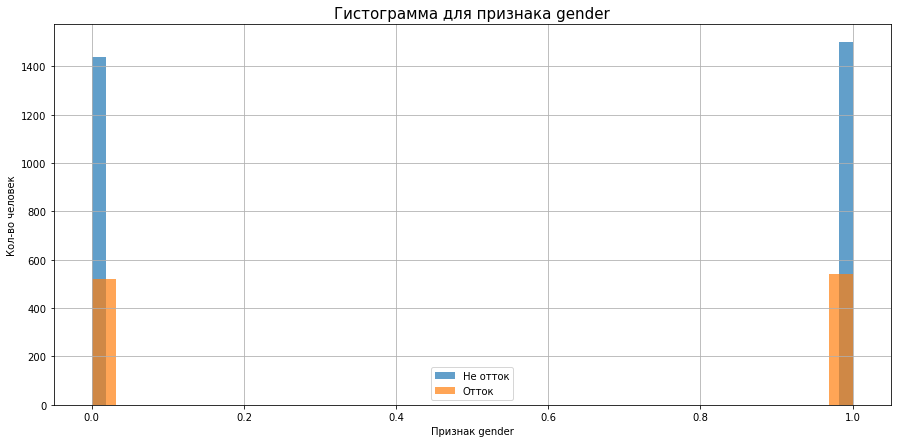

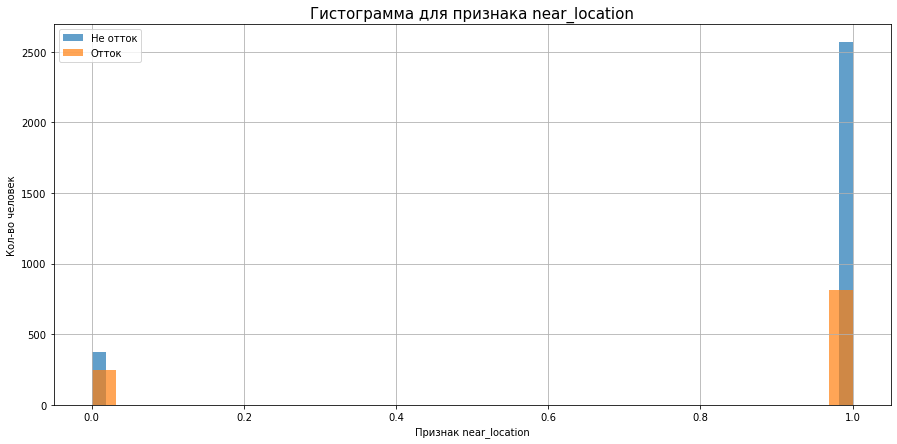

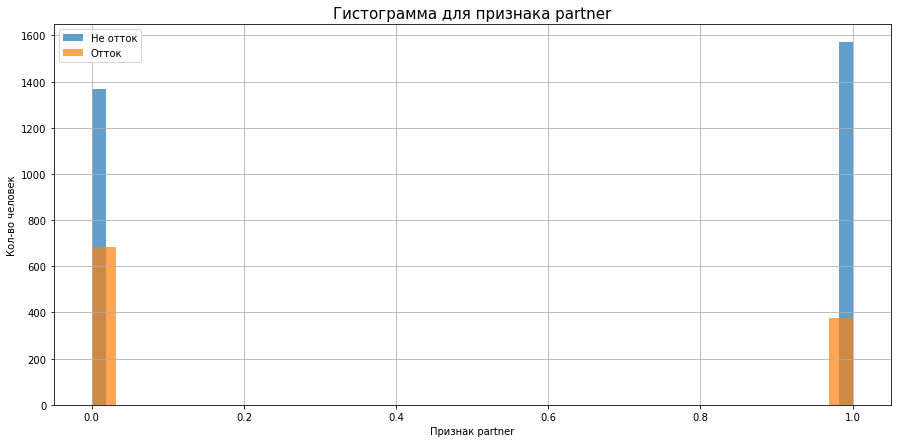

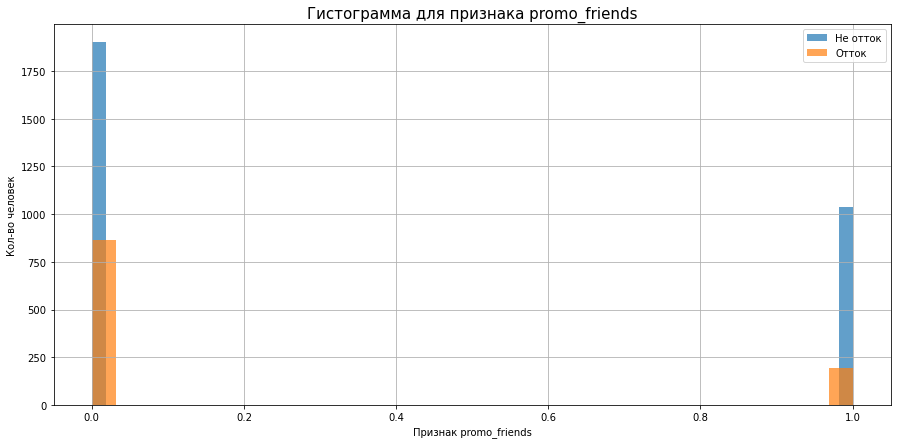

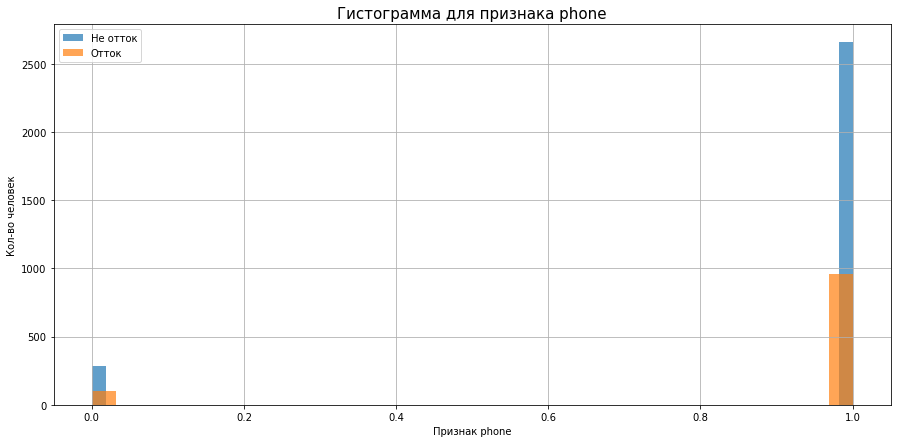

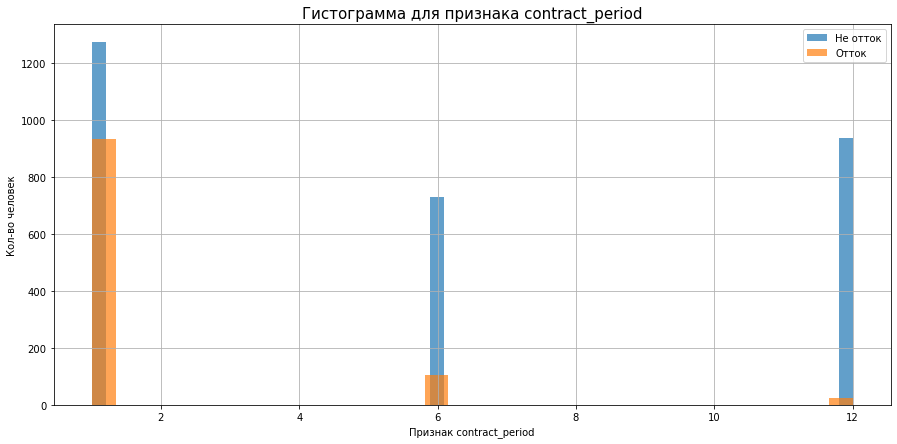

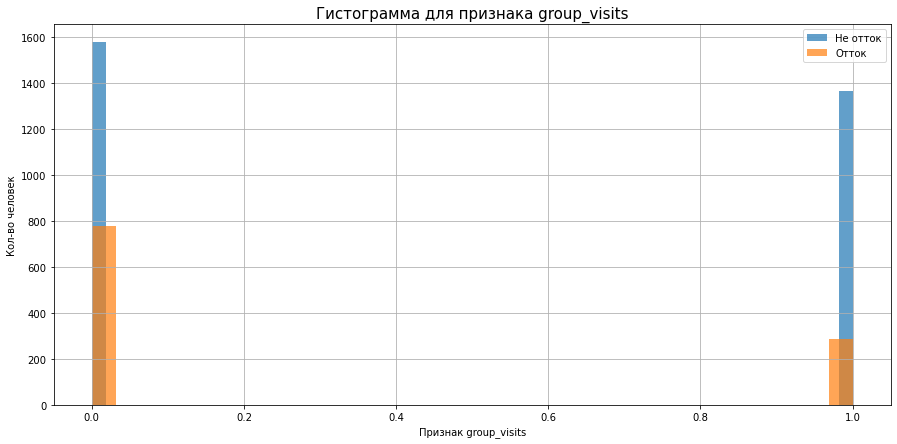

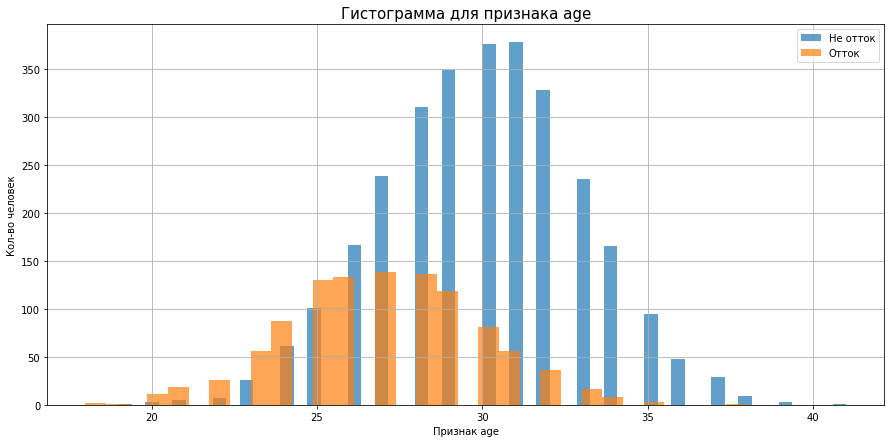

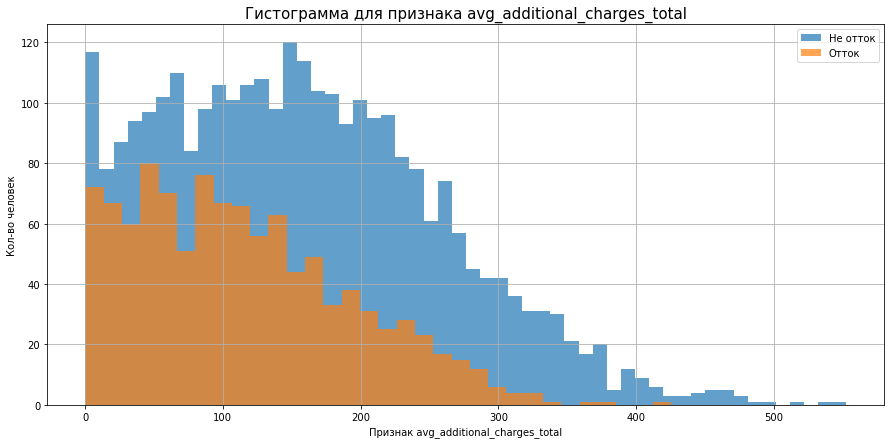

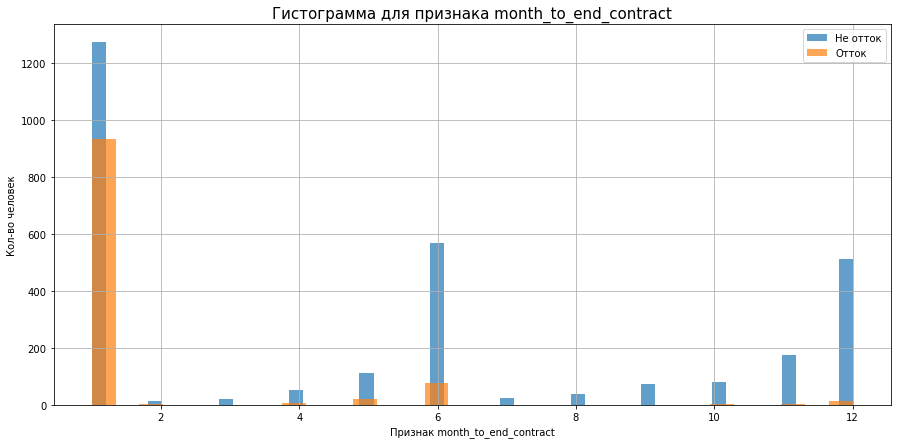

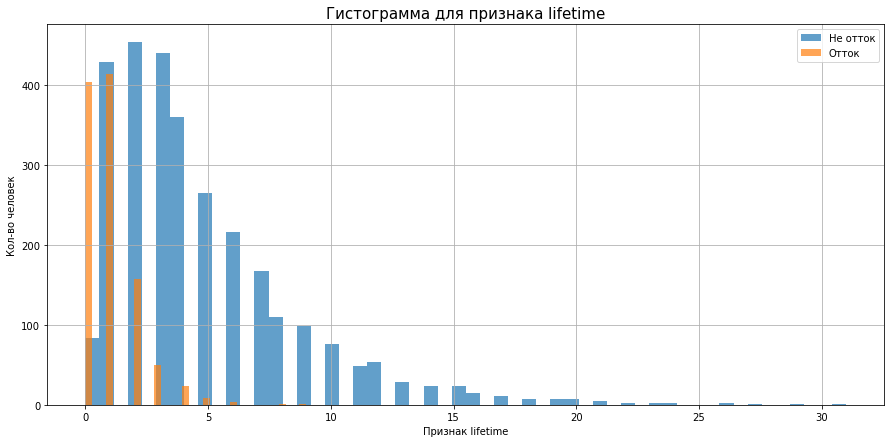

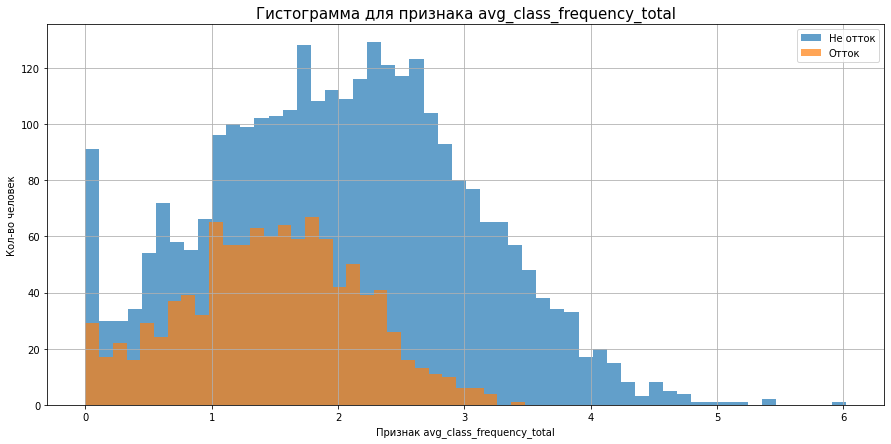

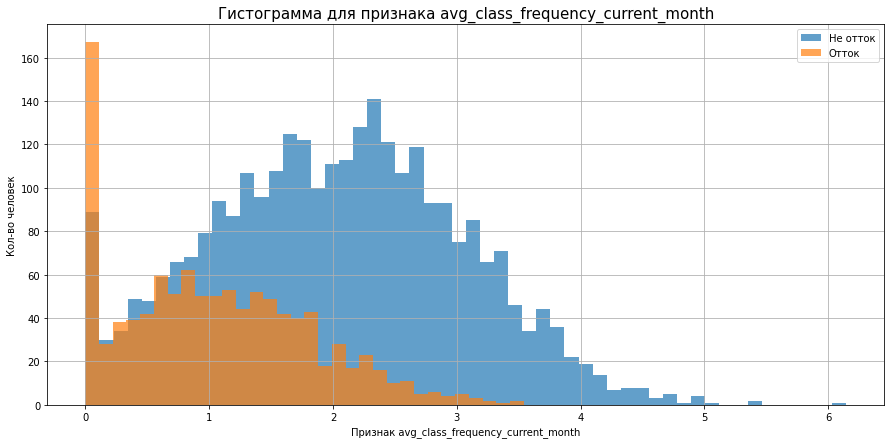

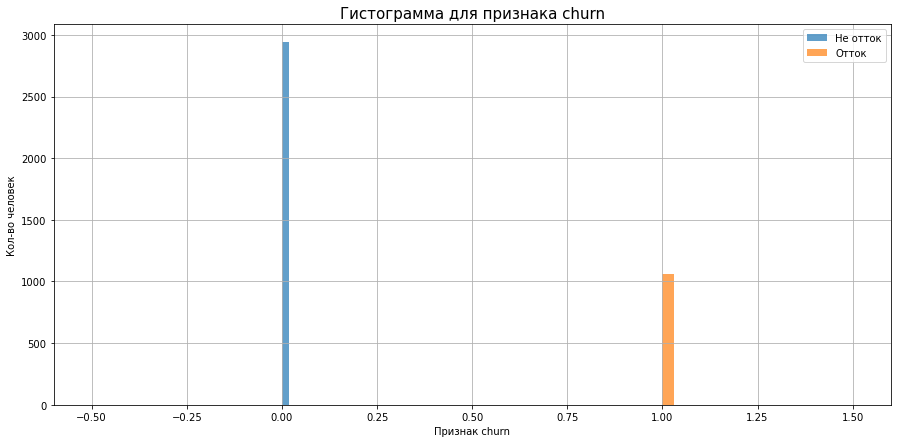

In [8]:
for column in data.columns:
    
    #чтобы вычислить кол-во необходимых интервалов для bins, извлечём из кол-ва значений квадратный корень
    
    bins0 = int(data.query('churn == 0')[column].shape[0]** 0.5)
    bins1 = int(data.query('churn == 1')[column].shape[0]** 0.5)
    
    plt.figure(figsize = (15,7))
    
    data.query('churn == 0')[column].hist(label='Не отток', bins=bins0, alpha=0.7)
    ax = data.query('churn == 1')[column].hist(label='Отток', bins=bins1, alpha=0.7)
    
    plt.title(f"Гистограмма для признака {column}", fontsize=15)
    plt.xlabel(f"Признак {column}")
    plt.ylabel('Кол-во человек')
    plt.legend()
    plt.show()

Гистограммы подтверждают выводы, сделанные на предыдущем шаге. Единственное отличие - метрики avg_class_frequency_total и avg_class_frequency_current_month, которые показывают, что данные могли быть неправильно размечены. А именно, те пользователи, которые были размечены как "не отток", но их частота равняется 0. Необходимо более внимательно посмотреть на эту категорию пользователей на предмет аномалий.

In [9]:
data.query('churn == 0 and avg_class_frequency_current_month == 0').describe(include='all').round(2)

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
count,47.00,47.00,47.00,47.00,47.00,47.00,47.00,47.00,47.00,47.00,47.00,47.00,47.0,47.0
mean,0.53,0.89,0.51,0.34,0.85,5.87,0.47,29.34,166.54,5.47,4.87,0.00,0.0,0.0
std,0.50,0.31,0.51,0.48,0.36,4.55,0.50,2.84,115.92,4.26,5.04,0.01,0.0,0.0
min,0.00,0.00,0.00,0.00,0.00,1.00,0.00,23.00,1.40,1.00,0.00,0.00,0.0,0.0
25%,0.00,1.00,0.00,0.00,1.00,1.00,0.00,28.00,69.56,1.00,2.00,0.00,0.0,0.0
50%,1.00,1.00,1.00,0.00,1.00,6.00,0.00,29.00,166.86,6.00,3.00,0.00,0.0,0.0
75%,1.00,1.00,1.00,1.00,1.00,12.00,1.00,31.00,221.75,9.50,6.00,0.00,0.0,0.0
max,1.00,1.00,1.00,1.00,1.00,12.00,1.00,34.00,515.39,12.00,27.00,0.06,0.0,0.0


Видим, что медианный лайфтайм таких пользователей - 3 месяца. Но есть также те, у кого лайфтайм - 0 месяцев. Вероятно, это новые пользователи, которые ещё не успели воспользоваться своим абонементом. Предлагаю тех пользователей, у которых (avg_class_frequency_current_month == 0) & (lifetime > 0) перезаписать в отток.

In [14]:
print(
    'Кол-во ложно определённых лояльных пользоваталей:', 
      data.query('churn == 0 and avg_class_frequency_current_month == 0 and lifetime > 0')['lifetime'].count()
     )

print(
    f"% ложно определённых лояльных пользоваталей: {data.query('churn == 0 and avg_class_frequency_current_month == 0 and lifetime > 0')['lifetime'].count() / data.shape[0]: .2%}"
     )

Кол-во ложно определённых лояльных пользоваталей: 46
% ложно определённых лояльных пользоваталей:  1.15%


In [15]:
data.loc[(data['churn'] == 0) & (data['avg_class_frequency_current_month'] == 0) & (data['lifetime'] > 0), 'churn'] = 1

#### Выводы

Видим, что гистаграмма подтверждает выводы, обозначенные анализом describe(). Была обнаружена часть неверно распределённых пользователей. Тем не менее, их доля настолько незначительна, что нет смысла делать перерасчёты и заново сроить гистограммы.

### Матрица корреляций

Посмотрим на корреляцию признаков в разрезе отток/не отток и построим на их основе хтитмэп.

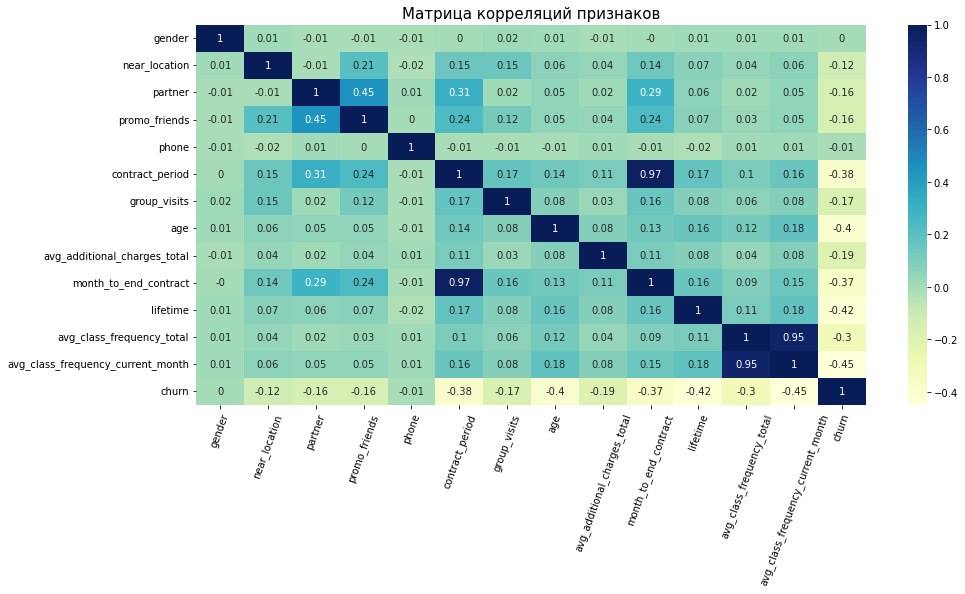

In [16]:
plt.figure(figsize = (15,7))
sns.heatmap(
    data.corr().round(2), 
    annot=True, 
    cmap="YlGnBu"
) 
plt.title('Матрица корреляций признаков', fontsize=15)
plt.xticks(rotation=70)
plt.show()

#### Выводы

Видим, что наиболее сильной положительной корреляцией для неоттока являются следующие связки (что может приводить к мультиколлинеарности):

- contract_period - month_to_end_contract (0.97)
- avg_class_frequency_total - avg_class_frequency_current_month (0.95)

Средней положительной корреляцией:
- promo_friends - partner (0.45)

Сильных отрицательных корреляций не обнаружено.

Конкретно для категории оттока, то можно выявить следующие отрицательные корреляции средней силы:

- avg_class_frequency_current_month - churn (-0.45)
- lifetime - churn (-0.42)
- age - churn (-0.4)
- contract_period - churn (-0.38)
- month_to_end_contract - churn (-0.37)

То есть, чем меньше частота посещений, лайфтайм, возраст и срок абонемента, тем более вероятно, что пользователь попадёт в категорию оттока.

## Прогнозирование оттока клиентов

Для прогнозирования оттока/неоттока клиентов воспользуемся бинарной классификацией. Для начала подготовим данные.

In [17]:
#разделим датасет на матрицу и признаки

X = data.drop('churn', axis=1)
y = data['churn']

#разобьём данные на обучающую и валидационную выборки

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

#приведём данные к стандартизации

scaler = StandardScaler()

X_train_st = scaler.fit_transform(X_train)
X_test_st = scaler.transform(X_test)

Обучим модель логистической регрессией и случайным лесом, т.к. именно они отвечают заявленной цели.

In [18]:
#обучаем модель логистической регрессии и строим прогноз

lr_model = LogisticRegression(solver='liblinear', random_state=0)
lr_model.fit(X_train_st, y_train)

lr_predictions = lr_model.predict(X_test_st)
lr_probabilities = lr_model.predict_proba(X_test_st)[:,1]

In [19]:
#обучаем модель случайного леса и строим прогноз

rf_model = RandomForestClassifier(n_estimators=100, random_state=0)
rf_model.fit(X_train_st, y_train)

rf_predictions = rf_model.predict(X_test_st)
rf_probabilities = rf_model.predict_proba(X_test_st)[:, 1]

Оценим работу моделей на валидационной выборке. Выведем метрики accuracy, precision и recall для того, чтобы оценить качество работы моделей.

In [20]:
lr_result = classification_report(y_test, lr_predictions)
rf_result = classification_report(y_test, rf_predictions)

print("Отчёт по логистической регрессии:")
print(lr_result)
print()
print("Отчёт по случайному лесу:")
print (rf_result)

Отчёт по логистической регрессии:
              precision    recall  f1-score   support

           0       0.94      0.96      0.95       590
           1       0.89      0.81      0.85       210

    accuracy                           0.92       800
   macro avg       0.91      0.89      0.90       800
weighted avg       0.92      0.92      0.92       800


Отчёт по случайному лесу:
              precision    recall  f1-score   support

           0       0.94      0.95      0.95       590
           1       0.86      0.84      0.85       210

    accuracy                           0.92       800
   macro avg       0.90      0.90      0.90       800
weighted avg       0.92      0.92      0.92       800



Также построим confusion matrix для наших моделей.

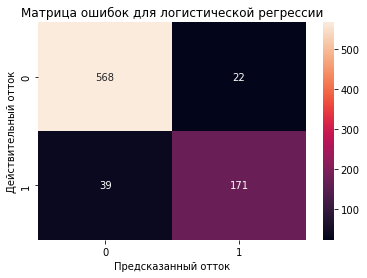

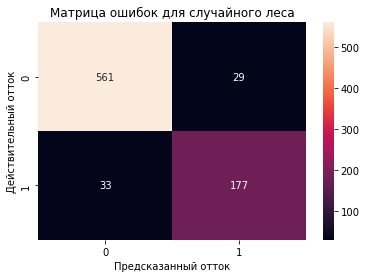

In [21]:
lr_cm = confusion_matrix(y_test, lr_predictions)
rf_cm = confusion_matrix(y_test, rf_predictions)

sns.heatmap(lr_cm, annot=True, fmt='g')
plt.title('Матрица ошибок для логистической регрессии')
plt.xlabel('Предсказанный отток')
plt.ylabel('Действительный отток')
plt.show()

sns.heatmap(rf_cm, annot=True, fmt='g')
plt.title('Матрица ошибок для случайного леса')
plt.xlabel('Предсказанный отток')
plt.ylabel('Действительный отток')
plt.show()

Т.к. при построении корреляций мы видели мультиколлинеарные связи, попробуем применить регуляризацию.

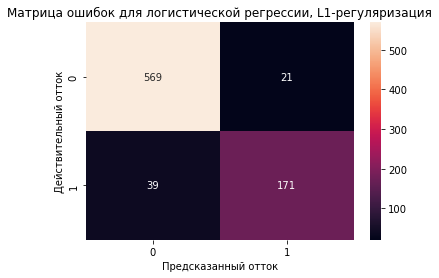

Отчёт по логистической регрессии, L1-регуляризация
              precision    recall  f1-score   support

           0       0.94      0.96      0.95       590
           1       0.89      0.81      0.85       210

    accuracy                           0.93       800
   macro avg       0.91      0.89      0.90       800
weighted avg       0.92      0.93      0.92       800



In [22]:
#применяем L1-регуляризацию

lr_model_l1 = LogisticRegression(solver='liblinear', penalty='l1', random_state=0)
lr_model_l1.fit(X_train_st, y_train)

lr_predictions_l1 = lr_model_l1.predict(X_test_st)
lr_probabilities_l1 = lr_model_l1.predict_proba(X_test_st)[:,1]

#строим матрицу ошибок

sns.heatmap(confusion_matrix(y_test, lr_predictions_l1), annot=True, fmt='g')
plt.title('Матрица ошибок для логистической регрессии, L1-регуляризация')
plt.xlabel('Предсказанный отток')
plt.ylabel('Действительный отток')
plt.show()

#выводим отчёт

print("Отчёт по логистической регрессии, L1-регуляризация")
print(classification_report(y_test, lr_predictions_l1))

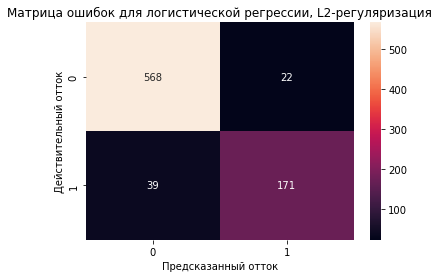

Отчёт по логистической регрессии, L2-регуляризация
              precision    recall  f1-score   support

           0       0.94      0.96      0.95       590
           1       0.89      0.81      0.85       210

    accuracy                           0.92       800
   macro avg       0.91      0.89      0.90       800
weighted avg       0.92      0.92      0.92       800



In [35]:
#применяем L2-регуляризацию

lr_model_l2 = LogisticRegression(solver='liblinear', penalty='l2', random_state=0)
lr_model_l2.fit(X_train_st, y_train)

lr_predictions_l2 = lr_model_l2.predict(X_test_st)
lr_probabilities_l2 = lr_model_l2.predict_proba(X_test_st)[:,1]

#строим матрицу ошибок

sns.heatmap(confusion_matrix(y_test, lr_predictions_l2), annot=True, fmt='g')
plt.title('Матрица ошибок для логистической регрессии, L2-регуляризация')
plt.xlabel('Предсказанный отток')
plt.ylabel('Действительный отток')
plt.show()

#выводим отчёт

print("Отчёт по логистической регрессии, L2-регуляризация")
print(classification_report(y_test, lr_predictions_l2))

Видмим, что регуляризация не дала существенного улучшения. L1-регуляризация немного повысила accuracy, но при этом определение оттока осталось на том же уровне. Вряд ли этой метрике стоит сильно доверять, т.к. наши выборки не являются до конца сбалансированными.

### Выводы

Мы видим, что логистическая регрессия показывает более точное прогнозирование оттока True Positive в когорте оттока (0.89 против 0.86 для случайного леса). Тем не менее, качество прогнозирования от всех значений (recall) у логистической регрессии ниже (0.81 против 0.84). Если мы посмотрим на матрицу ошибок, то видим, что случайный лес чаще прогнозирует отток и чаще негативит, обнаруживая False Positive результаты.

Если принять, что для фитнес-центра лучше неверно определить человека, как относящегося к группе риска (оттока), чем не определить, то мы можем сделать вывод, что модель случайного леса является более предпочтительной для фитнес-центра, т.к.  ложные срабатывания не несут критической значимости.

Тем не менее, это лишь предположение. Более точно можно об этом говорить, если будут известны себестоимость и LTV клиента. От этого может быть понятно, насколько прибыльно применять меры по предотвращению оттока, и не будут ли ложноположительные результаты в минус.

## Кластеризация клиентов

### Дендрограмма

Попробуем кластеризовать клиентов на группы. Для этого стандартизируем данные и отрисуем дендрограмму.

In [24]:
data_sc = scaler.fit_transform(data)

linked = linkage(data_sc, method='ward') 

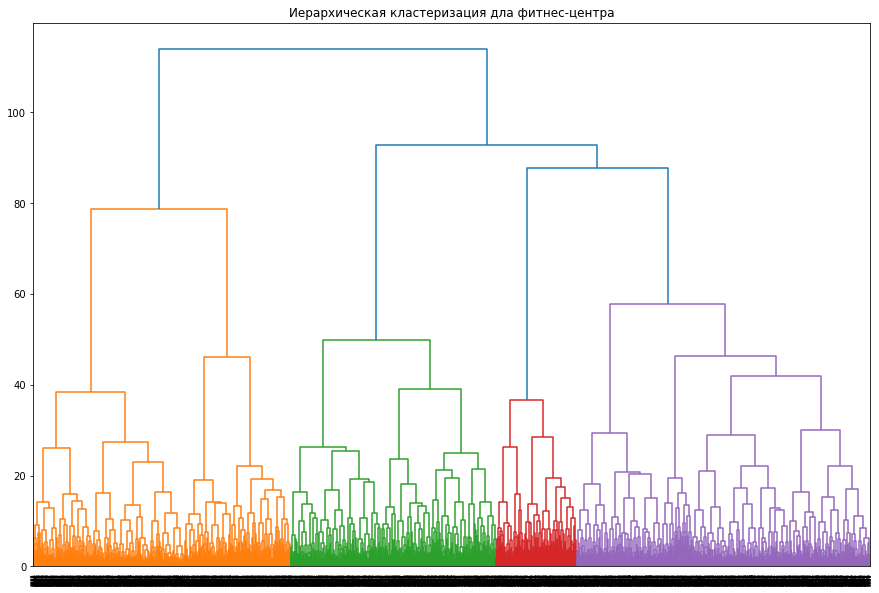

In [25]:
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.title('Иерархическая кластеризация дла фитнес-центра')
plt.show() 

#### Выводы

Исходя и3 полученной дендрограммы мы видим, что число оптимальных кластеров - 4. Если брать по линии 60, то оптимальным количеством кластеров будет 5. 

### K-Means-кластеризация

Обучим модель кластеризации K-Means и спрогнозируем возможные кластеры клиентов. За количество класетров возьмём найденное на предыдущем шаге число 5. 

In [26]:
km = KMeans(n_clusters=5, random_state=0)
labels = km.fit_predict(data_sc)
data['cluster_km'] = labels

Выведем статистику по средним значениям признаков по кластеру.

In [27]:
data.groupby('cluster_km').mean().round(2)

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
cluster_km,,,,,,,,,,,,,,
0,0.46,0.83,0.46,0.26,1.0,2.64,0.38,30.05,154.16,2.46,4.72,1.22,1.22,0.01
1,0.51,0.94,0.77,0.56,1.0,11.20,0.56,29.91,162.43,10.23,4.70,2.03,2.02,0.02
2,0.55,0.84,0.36,0.21,1.0,2.73,0.44,29.97,159.03,2.52,4.59,2.94,2.94,0.01
3,0.52,0.86,0.47,0.31,0.0,4.80,0.43,29.32,143.81,4.48,3.93,1.85,1.72,0.28
4,0.51,0.76,0.34,0.18,1.0,1.66,0.26,26.96,115.84,1.60,1.03,1.41,1.00,1.00


Видим, что K-Means чётко определил категорию оттока (4), в которой ярко отображены признаки, описанные нами на этапах describe, histogram (далеко от дома, лайфтайм 1 месяц, низкая частота посещений и др.)

Группа (1) описывает наиболее лояльных клиентов, которые покупают абонемент, охотно делятся промо с друзьями, предпочитают групповые занятия и показывают самые высокие доп. траты. Хотя, наиболее ярко выраженной характеристикой является, скорее, то, что эти люди входят в компанию-партнёра (77% пользователей) и для них фитнес-центр ближе всего к дому. 

В группе (2) находятся пользователи с наиболее высокой посещаемостью - 3 раза в неделю. 

В группе (3) - пользователи, которые покупают абонемент на длительное время (3-6 месяцев). При этом они не оставляют контактный телефон для связи. Эта же группа больше всех рискует уйти в отток (28%) Остальные признаки для них выражены неярко.

О группе (0) сложно что-то сказать, т.к. она не показывает каких-то ярко выраженных признаков. У неё высокий лайфтайм (4.76) при низком риске оттока - 1%. При этом, клинеты в этой группе стабильно покупают абонемент на 3 месяца.

### Распределение признаков

Посмотрим распределение признаков для кластеров. Для этого напишем функцию, которая будет строить гистограммы по каждому кластеру.

In [28]:
def cluster_hist (df, cluster):
    
    for column in data.columns:
           
        bins0 = int(data.query('cluster_km == @cluster')[column].shape[0]** 0.5)

        data.query('cluster_km == @cluster')[column].hist(bins=bins0)

        plt.title(f"Гистограмма для признака {column}, кластер - {cluster}", fontsize=15)
        plt.xlabel(f"Признак {column}")
        plt.ylabel('Кол-во человек')

        plt.show()

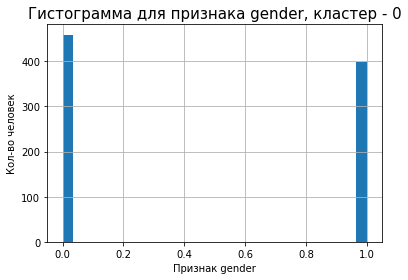

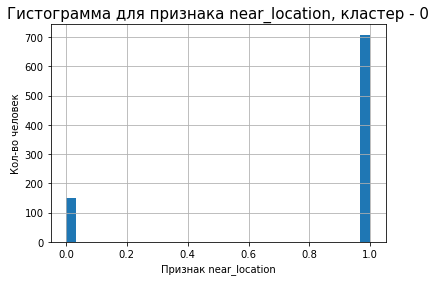

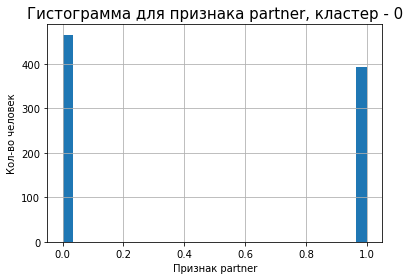

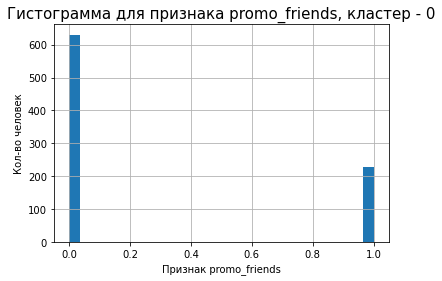

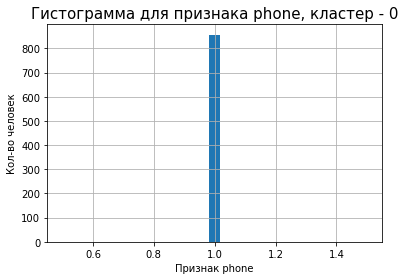

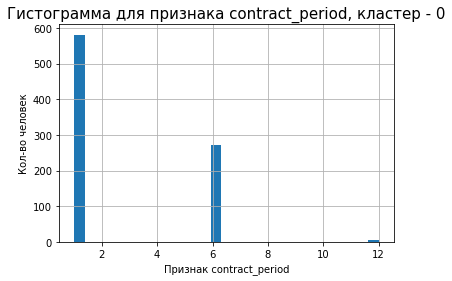

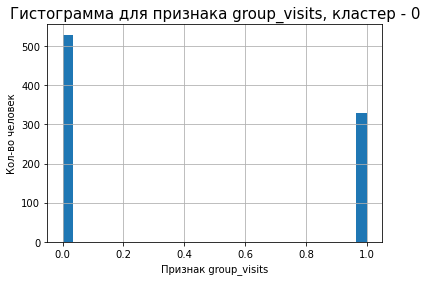

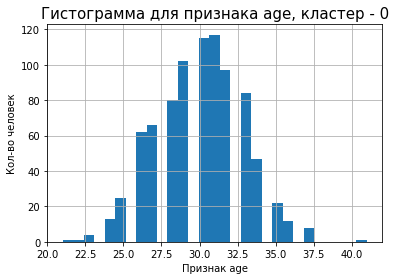

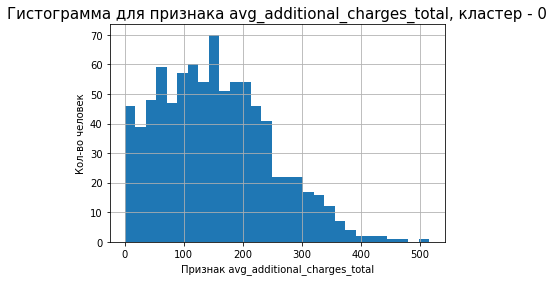

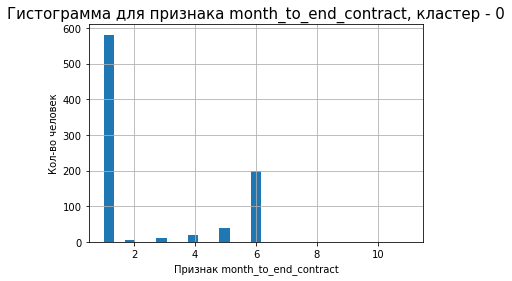

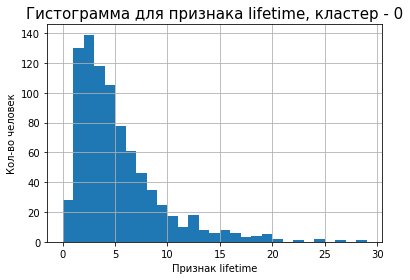

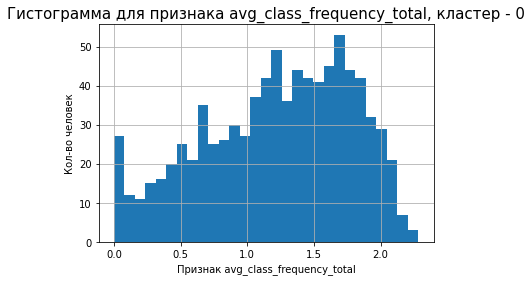

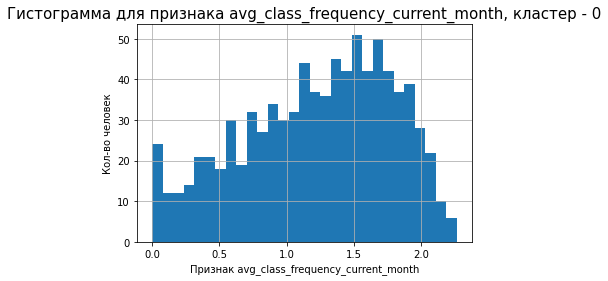

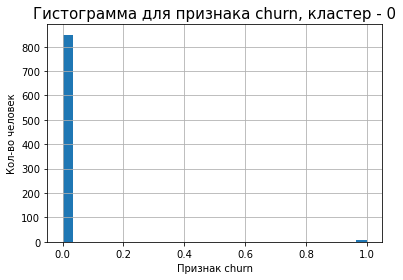

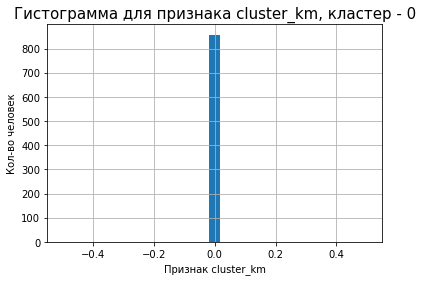

In [29]:
cluster_hist(data, 0)

Кластер (0):

- живут близко к фитнес-центру;
- не делятся промо с друзьями;
- покупают абонемент на 1 или 6 месяцев;
- наиболее распространённый возраст от 28 до 31;
- средний доп. чек до 150;
- до конца абонемента остался 1 месяц, реже - 6;
- наиболее распространённый лайфтайм 2-5 месяцев;
- ходят в зал 1-2 раза/неделю; 
- посещаемость в месяц стабильная;
- оттока практически не наблюдается.

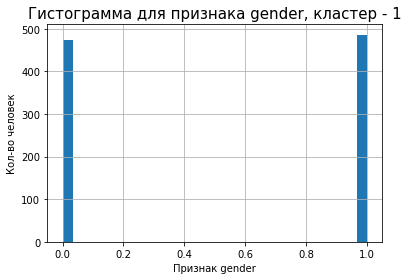

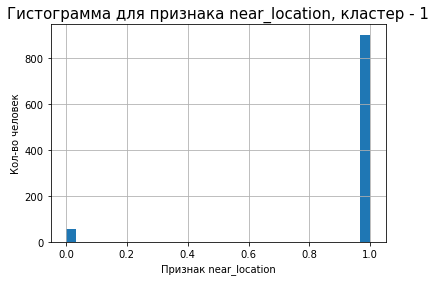

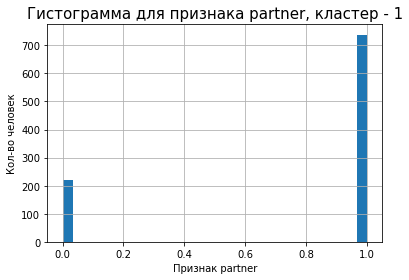

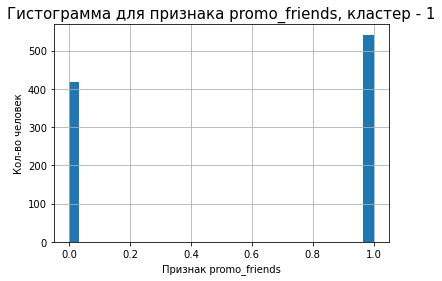

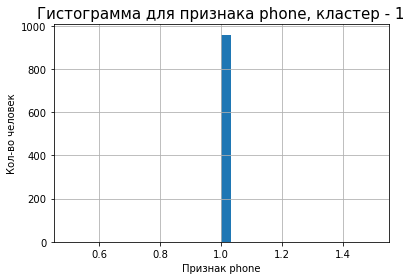

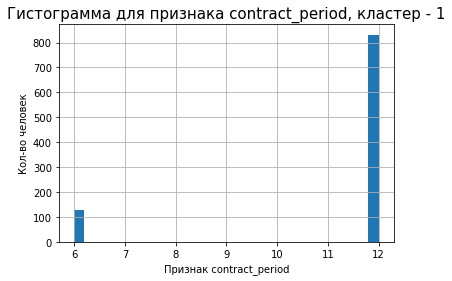

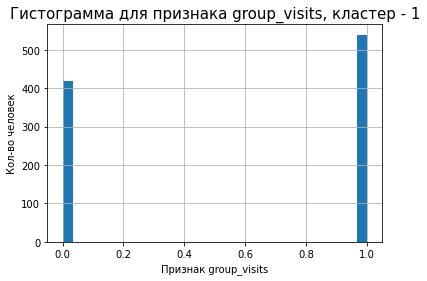

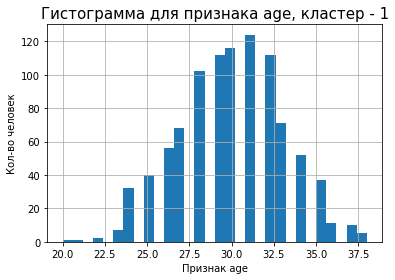

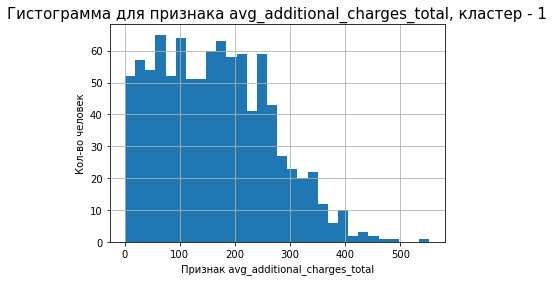

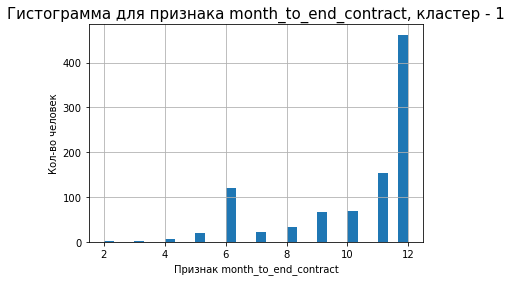

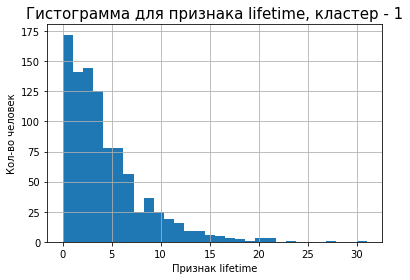

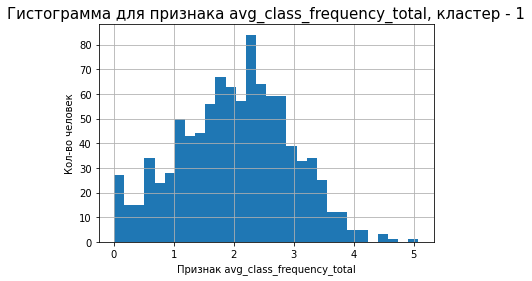

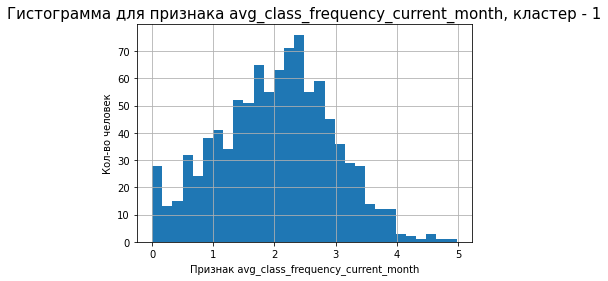

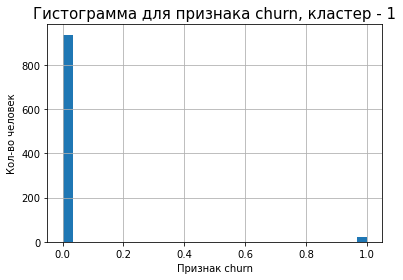

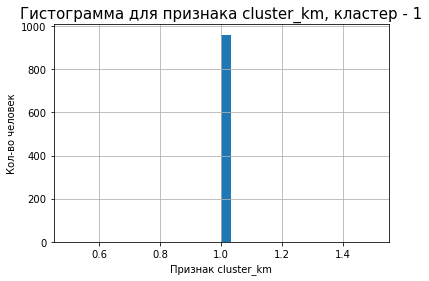

In [30]:
cluster_hist(data, 1)

Кластер (1):

- живут близко к фитнес-центру;
- относятся к компании-партнёру;
- охотно делятся промо;
- покупают абонемент на 12, реже - на 6 месяцев;
- любят групповые занятия;
- наиболее распространённый возраст от 28 до 32;
- средний доп. чек до 250;
- до конца абонемента осталось 12 месяцев, реже - 6, 11;
- наиболее распространённый лайфтайм 0-4 месяцев;
- ходят в зал 1,5-3 раза/неделю; 
- оттока практически не наблюдается.

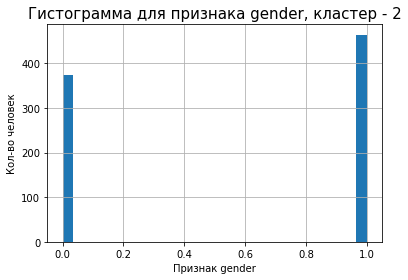

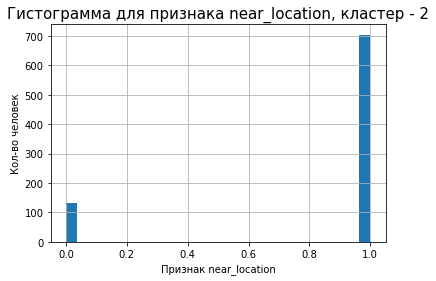

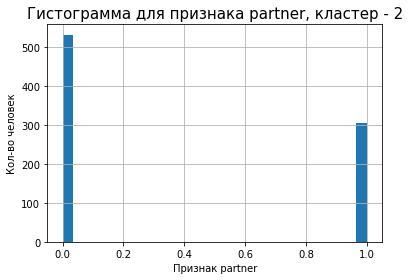

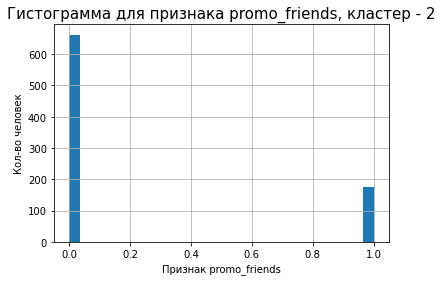

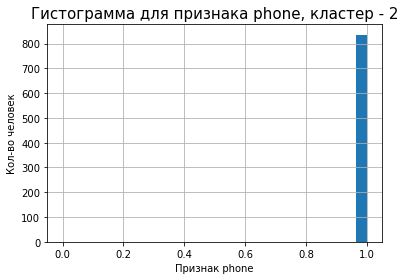

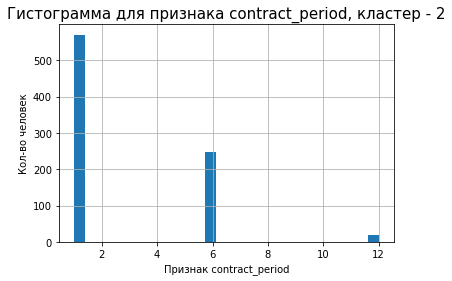

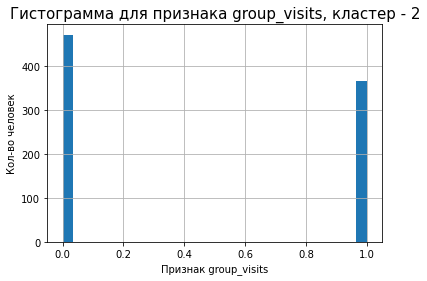

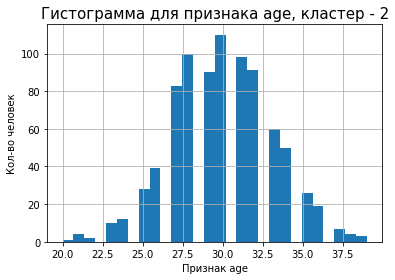

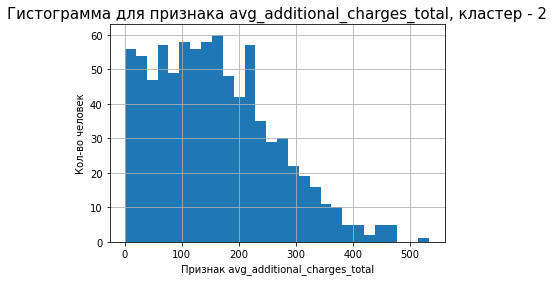

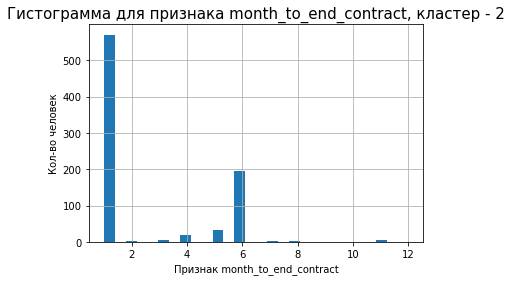

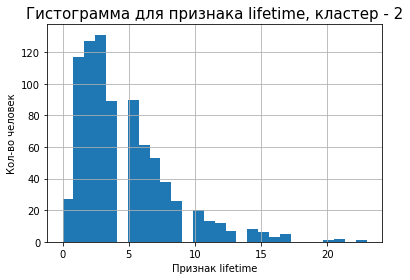

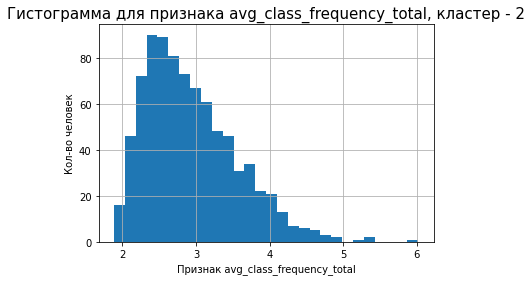

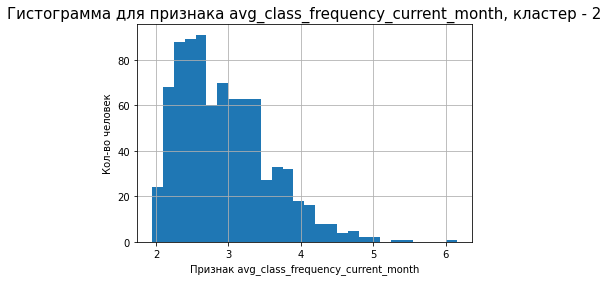

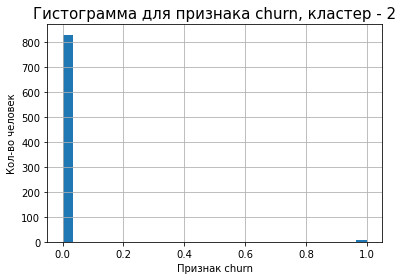

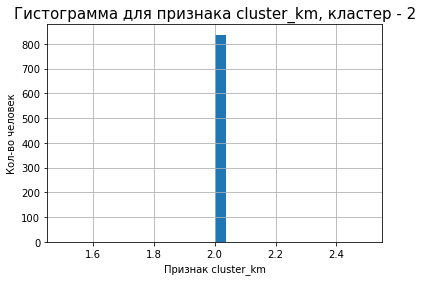

In [31]:
cluster_hist(data, 2)

Кластер (2):

- живут близко к фитнес-центру;
- не делятся промо;
- покупают абонемент на 1 месяц, реже - на 6;
- наиболее распространённый возраст от 27 до 32;
- средний доп. чек до 200;
- до конца абонемента остался 1 месяц, реже - 6;
- наиболее распространённый лайфтайм 1-3 месяцев;
- ходят в зал 2-3 раза/неделю; 
- оттока практически не наблюдается.

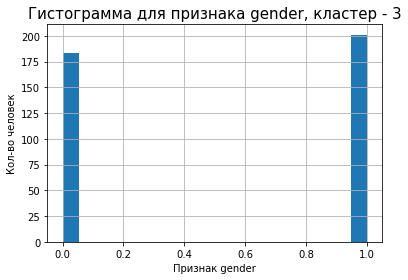

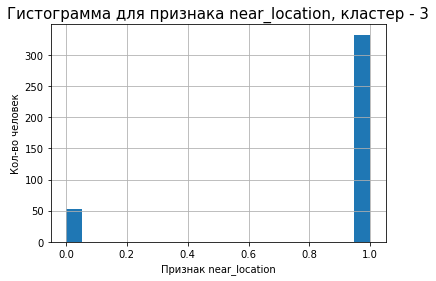

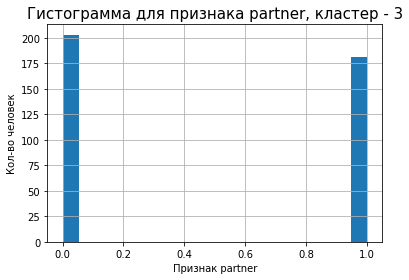

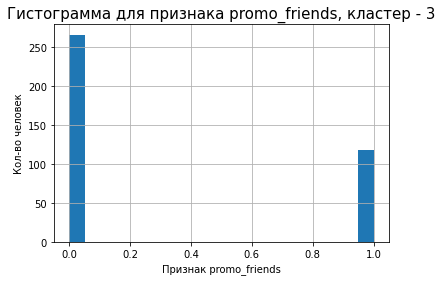

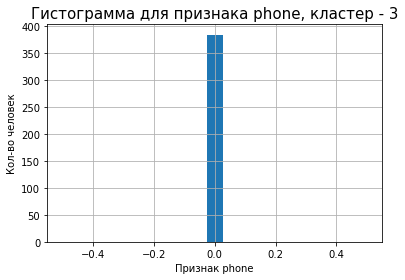

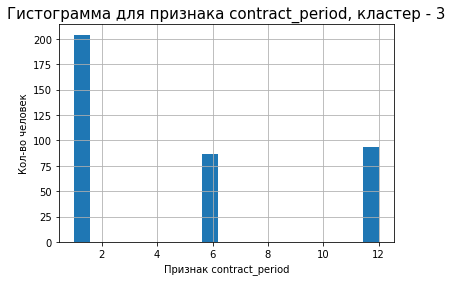

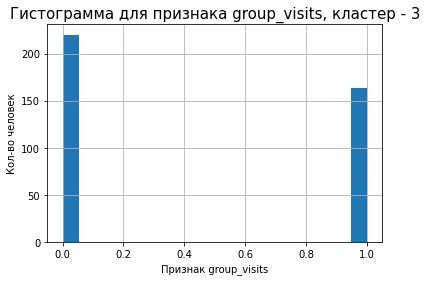

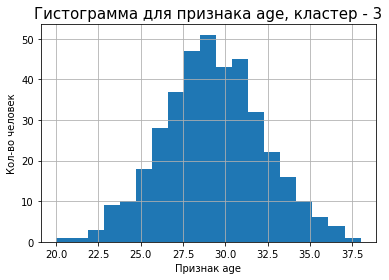

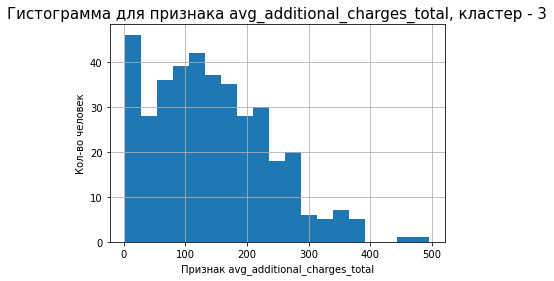

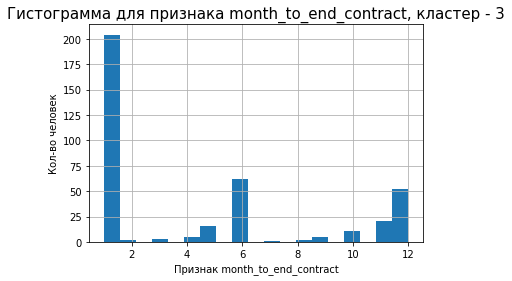

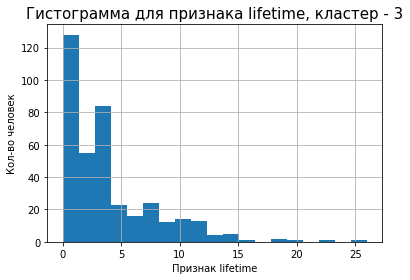

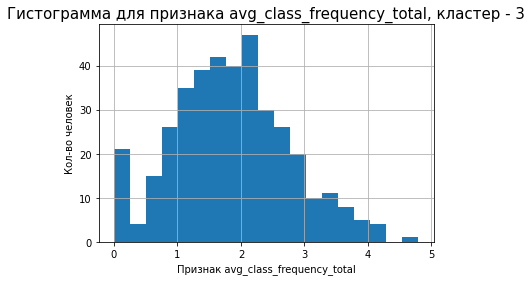

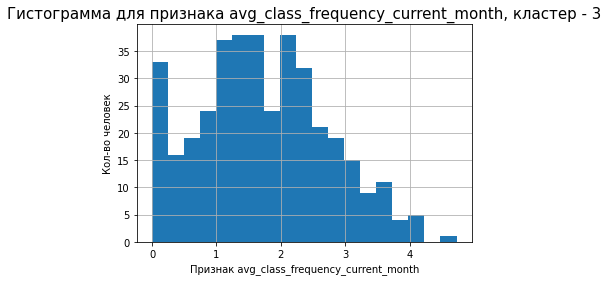

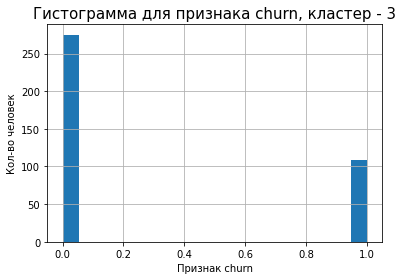

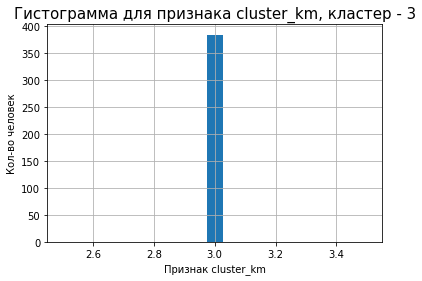

In [32]:
cluster_hist(data, 3)

Кластер (3):

- живут близко к фитнес-центру;
- половина относится к компании-партнёру;
- почти не делятся промо;
- не оставляют свой контактный телефон;
- покупают абонемент на 1 месяц, реже - на 6, 12;
- наиболее распространённый возраст от 27 до 31;
- средний доп. чек чуть меньше 200;
- до конца абонемента остался 1 месяц, реже - 6, 12;
- наиболее распространённый лайфтайм 1, 3 месяца, большой разброс по времени лайфтайма;
- ходят в зал 1-2 раза/неделю; 
- есть риск оттока в сравнении с другими группами.

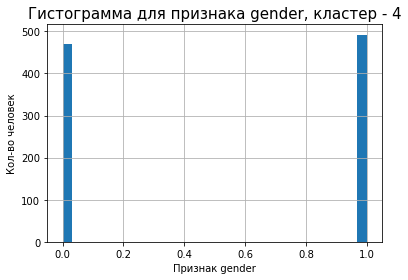

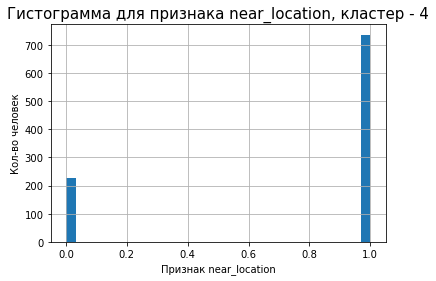

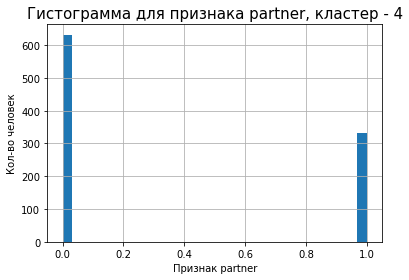

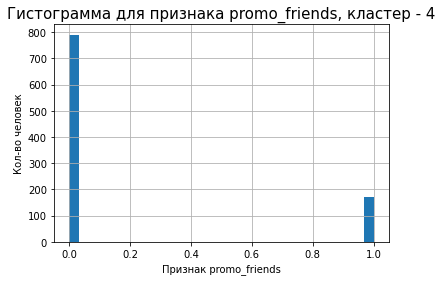

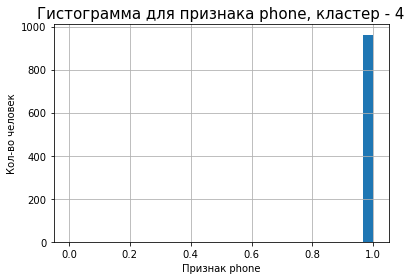

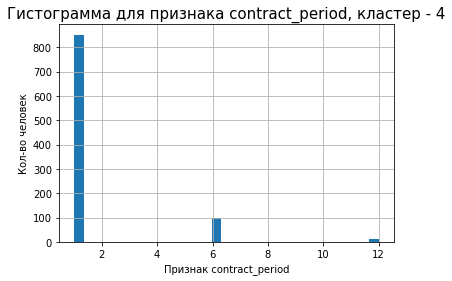

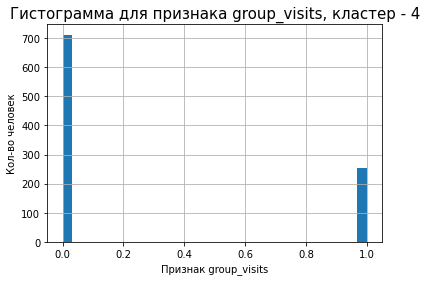

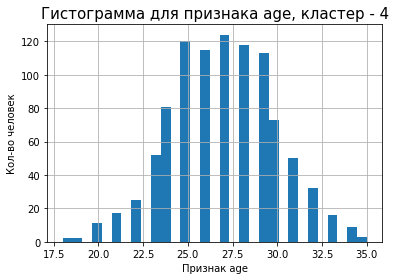

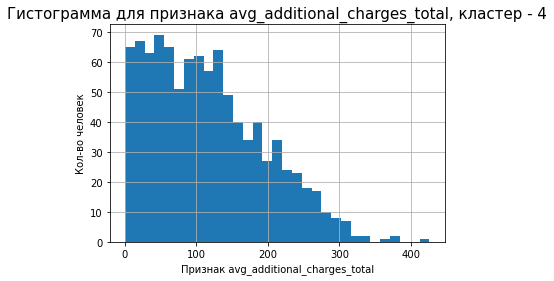

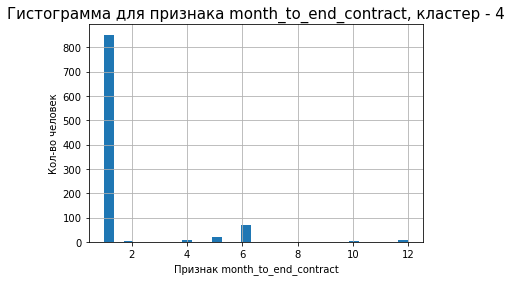

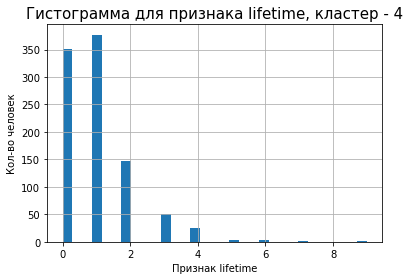

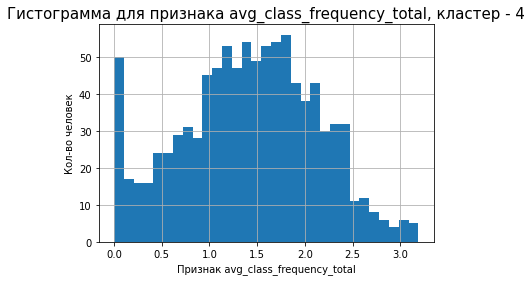

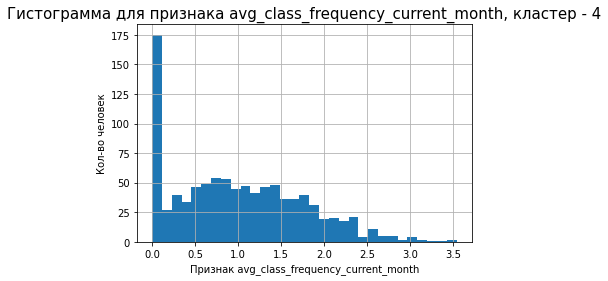

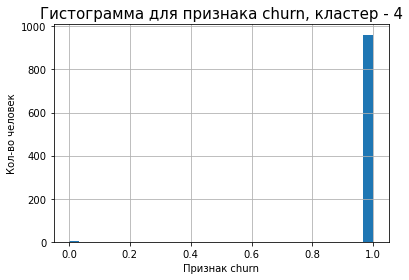

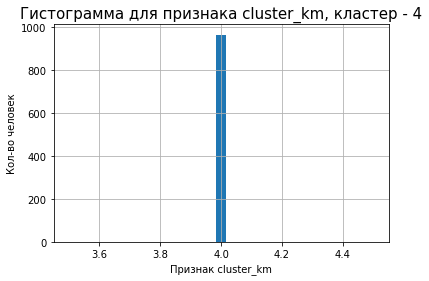

In [33]:
cluster_hist(data, 4)

Кластер (4):

- в основном, живут близко к фитнес-центру;
- не делятся промо;
- покупают абонемент на 1 месяц;
- не любят групповые занятия;
- наиболее распространённый возраст от 25 до 30 (что является самой молодой когортой);
- средний доп. чек до 150;
- до конца абонемента остался 1 месяц;
- наиболее распространённый лайфтайм 1-2 месяца;
- ходят в зал 1-2 раза/неделю; 
- почти 100% отток.

#### Выводы

Подробное рассмотрение гистограмм позволяет создать типичные портреты пользователей фитнес-центра. Наиболее важными являются кластер (4), т.к. это группа тех пользователей, которые меньше всего взаимодействуют с компанией и наиболее подвержены оттоку. Также очень важен кластер (1), т.к. это лояльные пользователи, которые приносят стабильную прибыль. Над лояльностью кластера (3) необходимо работать, т.к. он находится в группе риска. Остальные кластеры показывают средние результаты и, вероятно, с течением времени могут плавно переходит в кластер (4).

### Доля оттока

Посчитаем для каждого кластера долю оттока, чтобы подтвердить сделанные выше выводы (или опровергнуть).

In [34]:
data.groupby('cluster_km').agg({'churn': ['count', 'sum']})

churn     
           count  sum
cluster_km           
0            857    8
1            959   22
2            837    7
3            384  109
4            963  961

Выводы выше можно считать подтверждёнными, (4) - наиболее подверженный оттоку кластер. В кластере (3) оттоку подвержена 1/4 клиентов.

## Выводы и рекомендации

Мы проанализировали данные фитнес-центра, провели подготовку и сформулировали первичные гипотезы о том, какие показатели могут напрямую влиять на отток. Мы выявили, что, чем меньше частота посещений, лайфтайм, возраст и срок абонемента, тем более вероятно, что пользователь попадёт в категорию оттока.

Затем иы разделили данные на тренировочную и валидационную выборки, стандартизировали и обучили на них алгоритмы логистической регрессии и случайного леса. По результатам обучения мы можем сделать следующие выводы.

Модель случайного леса является предпочтительней для прогнозирования, т.к. более точно определяет пользователей, которые могут попасть в отток (но из-за этого негативит, занося в отток даже тех пользователей, которые лояльны). 

Мы также кластеризовали пользователей на 5 групп, сформировав портреты критически важных групп клиентов. А именно:

Кластер (4) - отток:

- в основном, живут близко к фитнес-центру;
- не делятся промо;
- покупают абонемент на 1 месяц;
- не любят групповые занятия;
- наиболее распространённый возраст от 25 до 30 (что является самой молодой когортой);
- средний доп. чек до 150;
- до конца абонемента остался 1 месяц;
- наиболее распространённый лайфтайм 1-2 месяца;
- ходят в зал 1-2 раза/неделю; 
- почти 100% отток.

Кластер (3) - высокий риск оттока:

- живут близко к фитнес-центру;
- половина относится к компании-партнёру;
- почти не делятся промо;
- не оставляют свой контактный телефон;
- покупают абонемент на 1 месяц, реже - на 6, 12;
- наиболее распространённый возраст от 27 до 31;
- средний доп. чек чуть меньше 200;
- до конца абонемента остался 1 месяц, реже - 6, 12;
- наиболее распространённый лайфтайм 1, 3 месяца, большой разброс по времени лайфтайма;
- ходят в зал 1-2 раза/неделю; 
- есть риск оттока в сравнении с другими группами.

Кластер (1) - лояльные и платёжеспособные:

- живут близко к фитнес-центру;
- относятся к компании-партнёру;
- охотно делятся промо;
- покупают абонемент на 12, реже - на 6 месяцев;
- любят групповые занятия;
- наиболее распространённый возраст от 28 до 32;
- средний доп. чек до 250;
- до конца абонемента осталось 12 месяцев, реже - 6, 11;
- наиболее распространённый лайфтайм 0-4 месяцев;
- ходят в зал 1,5-3 раза/неделю; 
- оттока практически не наблюдается.

Рекомендации по этим кластерам:

1. Уделить огромное внимание кластерам (4), (3), чтобы предотвратить отток этой категории населения. Например, предлагать им скидки на абонемент на 3 мес., чтобы клиенты смогли преодолеть первичный порог входа. Также можно предлагать скидки на групповые занятия, т.к. известно, что клиенты, которые ходят в группы, остаются клиентами дольше. С уже ушедшими нужно проводить интервьюирование, чтобы понять, какие именно факторы повлияли на отток, и стараться вернуть пользователей обратно, путём нивелирования их проблем.
2. Занести пользователей из кластера (1) в категорию вип-клиентов, и стараться не терять их, предлагать скидки на полугодовые/годовые абонементы, чтобы максимально увеличить их лайфтайм. Предлагать допродажи.
3. Пользователи из кластера (0) и (2) оставить под наблюдением. Можно поробовать их стимулировать теми же средствами, которыми стимулируем группу 1.
